# Notebook 04: Clasificacion de Nodulos Pulmonares

Este notebook entrena un clasificador de nodulos pulmonares (benigno/maligno).

## Contenido:
1. **Dataset**: Kaggle lungnodemalignancy (6691 patches con etiquetas)
2. **Modelo**: ResNet18 adaptado para grayscale
3. **Entrenamiento**: Train/Val/Test split
4. **Evaluacion**: Metricas, matriz de confusion, curva ROC

---

## Dataset

| Propiedad | Valor |
|-----------|-------|
| Fuente | [Kaggle: lungnodemalignancy](https://www.kaggle.com/datasets/kmader/lungnodemalignancy) |
| Total patches | 6691 |
| Tamaño | 64x64 pixeles |
| Clases | 0 (Benigno): 4165, 1 (Maligno): 2526 |
| Formato | HDF5 |

---

## 1. Configuracion del Entorno

In [2]:
# Detectar si estamos en Google Colab
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Ejecutando en Google Colab")
    print("="*50)
    
    # Instalar dependencias
    import subprocess
    paquetes = ['SimpleITK', 'scikit-image', 'requests', 'tqdm']
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + paquetes)
    
    # Clonar repositorio
    repo_url = "https://github.com/Daspony/Imagenes-Biomedicas.git"
    repo_name = "Imagenes-Biomedicas"
    
    if not os.path.exists(f"/content/{repo_name}"):
        subprocess.run(["git", "clone", repo_url], cwd="/content", check=True)
    
    sys.path.insert(0, f"/content/{repo_name}")
    print("Configuracion de Colab completada\n")
    
else:
    print("Ejecutando localmente")
    print("="*50) 
    
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    
    print(f"Directorio de trabajo: {os.getcwd()}")
    print("Configuracion local completada\n")

Ejecutando localmente
Directorio de trabajo: c:\Users\Poney\Desktop\Imagenes Biomedicas\notebooks
Configuracion local completada



In [3]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import h5py

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nLibrerias importadas correctamente")

Dispositivo: cuda
GPU: NVIDIA GeForce RTX 2050

Librerias importadas correctamente


In [4]:
# Configuracion de rutas
if IN_COLAB:
    project_root = '/content/Imagenes-Biomedicas'
else:
    project_root = os.path.abspath('..')

# Rutas del dataset de Kaggle
DATA_DIR = os.path.join(project_root, 'data')
HDF5_PATH = os.path.join(DATA_DIR, 'all_patches.hdf5')
CSV_PATH = os.path.join(DATA_DIR, 'malignancy.csv')

# Verificar que existen los archivos
print(f"HDF5: {HDF5_PATH}")
print(f"  Existe: {os.path.exists(HDF5_PATH)}")
print(f"CSV: {CSV_PATH}")
print(f"  Existe: {os.path.exists(CSV_PATH)}")

HDF5: c:\Users\Poney\Desktop\Imagenes Biomedicas\data\all_patches.hdf5
  Existe: True
CSV: c:\Users\Poney\Desktop\Imagenes Biomedicas\data\malignancy.csv
  Existe: True


---

## 2. Modelo Clasificador

Usamos una arquitectura basada en **ResNet18** adaptada para imagenes medicas grayscale.

Alternativas disponibles:
- ResNet18/34/50
- DenseNet121
- EfficientNet-B0

In [5]:
class NoduleClassifier(nn.Module):
    """
    Clasificador de nodulos pulmonares basado en ResNet18
    
    Args:
        num_classes: Numero de clases (2: benigno/maligno)
        pretrained: Usar pesos pre-entrenados de ImageNet
    """
    def __init__(self, num_classes=2, pretrained=True):
        super(NoduleClassifier, self).__init__()
        
        # Cargar ResNet18
        self.backbone = models.resnet18(pretrained=pretrained)
        
        # Modificar primera capa para 1 canal (grayscale)
        # Promediamos los pesos de los 3 canales RGB
        original_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        
        # Inicializar con promedio de pesos RGB
        if pretrained:
            with torch.no_grad():
                self.backbone.conv1.weight = nn.Parameter(
                    original_conv.weight.mean(dim=1, keepdim=True)
                )
        
        # Modificar capa final
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


# Crear modelo
model = NoduleClassifier(num_classes=2, pretrained=True).to(device)
print(f"Clasificador creado")
print(f"Parametros: {sum(p.numel() for p in model.parameters()):,}")

c:\Users\Poney\Desktop\Imagenes Biomedicas\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Poney\Desktop\Imagenes Biomedicas\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Poney/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 79.5MB/s]


Clasificador creado
Parametros: 11,171,266


---

## 3. Dataset de Kaggle (HDF5)

Cargamos los patches y etiquetas del dataset de Kaggle.

In [6]:
# Cargar datos del HDF5
with h5py.File(HDF5_PATH, 'r') as f:
    print("Contenido del HDF5:")
    for key in f.keys():
        print(f"  {key}: {f[key].shape}, dtype={f[key].dtype}")
    
    # Cargar datos en memoria
    X = f['ct_slices'][:]  # (6691, 64, 64)
    y = f['slice_class'][:].flatten()  # (6691,)

print(f"\nDatos cargados:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  X range: [{X.min():.2f}, {X.max():.2f}]")
print(f"\nDistribucion de clases:")
print(f"  Benigno (0): {(y == 0).sum()}")
print(f"  Maligno (1): {(y == 1).sum()}")

Contenido del HDF5:
  ct_slices: (6691, 64, 64), dtype=float32
  slice_class: (6691, 1), dtype=float64

Datos cargados:
  X shape: (6691, 64, 64)
  y shape: (6691,)
  X range: [-3024.00, 3071.00]

Distribucion de clases:
  Benigno (0): 4165
  Maligno (1): 2526


In [7]:
class KaggleNoduleDataset(Dataset):
    """
    Dataset para clasificacion usando datos de Kaggle
    """
    def __init__(self, X, y, transform=None):
        """
        Args:
            X: numpy array de patches (N, 64, 64)
            y: numpy array de etiquetas (N,)
            transform: transformaciones opcionales
        """
        self.X = X
        self.y = y.astype(np.int64)
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # Obtener patch y etiqueta
        patch = self.X[idx]
        label = self.y[idx]
        
        # Normalizar a [0, 1] si no esta normalizado
        if patch.max() > 1.0:
            patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
        
        # Convertir a tensor con canal
        patch = torch.FloatTensor(patch).unsqueeze(0)  # (1, 64, 64)
        
        if self.transform:
            patch = self.transform(patch)
        
        return patch, label


# Crear dataset completo
full_dataset = KaggleNoduleDataset(X, y)
print(f"Dataset creado: {len(full_dataset)} muestras")

Dataset creado: 6691 muestras


In [11]:
# Dividir en train/val/test (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size:.1%})")
print(f"Val: {len(val_dataset)} ({len(val_dataset)/total_size:.1%})")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size:.1%})")

# Crear DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nBatches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Train: 4683 (70.0%)
Val: 1003 (15.0%)
Test: 1005 (15.0%)

Batches - Train: 147, Val: 32, Test: 32


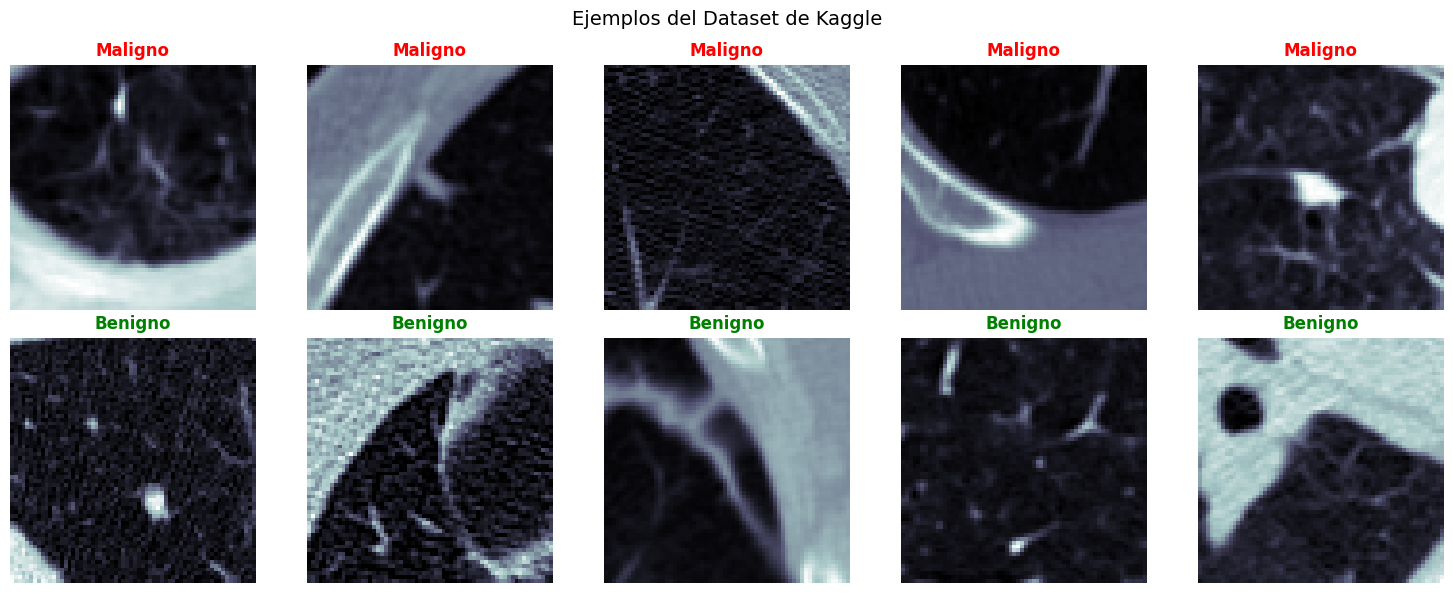

In [12]:
# Visualizar algunos ejemplos
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

class_names = ['Benigno', 'Maligno']
colors = ['green', 'red']

for i in range(10):
    patch, label = full_dataset[i * 600]  # Saltar para variedad
    axes[i].imshow(patch.squeeze(), cmap='bone')
    axes[i].set_title(f'{class_names[label]}', color=colors[label], fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Ejemplos del Dataset de Kaggle', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Entrena una epoca"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for patches, labels in loader:
        patches = patches.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total


def validate(model, loader, criterion, device):
    """Valida el modelo"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for patches, labels in loader:
            patches = patches.to(device)
            labels = labels.to(device)
            
            outputs = model(patches)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total


def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4):
    """
    Entrena el clasificador
    
    Args:
        model: Modelo clasificador
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validacion
        num_epochs: Numero de epocas
        lr: Learning rate
    
    Returns:
        history: Historial de entrenamiento
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Scheduler
        scheduler.step(val_loss)
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_classifier.pth')
        
        print(f"Epoch {epoch+1:02d}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")
    
    return history


print("Funciones de entrenamiento definidas")

Funciones de entrenamiento definidas


---

## 5. Entrenamiento

Entrenamos el clasificador con los datos reales de Kaggle.

In [14]:
# Entrenar el modelo
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4

print("Iniciando entrenamiento...")
print(f"Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}, Batch size: {BATCH_SIZE}")
print("="*60)

history = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE)

print("\nEntrenamiento completado!")

Iniciando entrenamiento...
Epochs: 15, LR: 0.0001, Batch size: 32
Epoch 01/15: Train Loss: 0.7111, Train Acc: 63.21% | Val Loss: 0.7447, Val Acc: 63.11%
Epoch 02/15: Train Loss: 0.5779, Train Acc: 70.25% | Val Loss: 0.7734, Val Acc: 37.09%
Epoch 03/15: Train Loss: 0.5227, Train Acc: 71.68% | Val Loss: 0.6730, Val Acc: 63.11%
Epoch 04/15: Train Loss: 0.4778, Train Acc: 74.44% | Val Loss: 0.7919, Val Acc: 63.11%
Epoch 05/15: Train Loss: 0.4958, Train Acc: 74.42% | Val Loss: 0.8081, Val Acc: 63.01%
Epoch 06/15: Train Loss: 0.4252, Train Acc: 78.18% | Val Loss: 1.2766, Val Acc: 63.01%
Epoch 07/15: Train Loss: 0.3964, Train Acc: 80.46% | Val Loss: 0.6646, Val Acc: 63.11%
Epoch 08/15: Train Loss: 0.4058, Train Acc: 78.65% | Val Loss: 0.7949, Val Acc: 63.11%
Epoch 09/15: Train Loss: 0.4274, Train Acc: 78.60% | Val Loss: 1.1384, Val Acc: 63.11%
Epoch 10/15: Train Loss: 0.3798, Train Acc: 80.25% | Val Loss: 0.6626, Val Acc: 64.01%
Epoch 11/15: Train Loss: 0.3888, Train Acc: 79.76% | Val Loss: 0

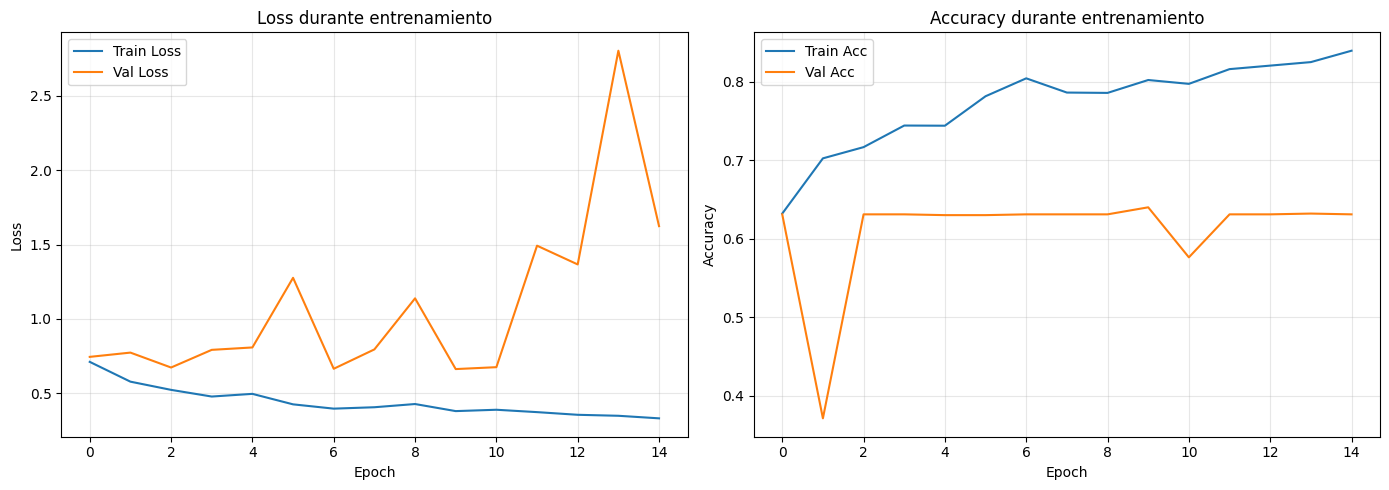


Mejor Val Accuracy: 64.01%


In [15]:
# Visualizar curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss durante entrenamiento')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy durante entrenamiento')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMejor Val Accuracy: {max(history['val_acc']):.2%}")

In [16]:
def evaluate_model(model, test_loader, device):
    """
    Evalua el modelo en el conjunto de test
    
    Returns:
        y_true: Etiquetas reales
        y_pred: Predicciones
        y_prob: Probabilidades de clase maligna
    """
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    
    with torch.no_grad():
        for patches, labels in test_loader:
            patches = patches.to(device)
            
            outputs = model(patches)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probs[:, 1].cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_prob)


def plot_confusion_matrix(y_true, y_pred, classes=['Benigno', 'Maligno']):
    """Visualiza matriz de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           ylabel='Etiqueta Real',
           xlabel='Prediccion')
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, str(cm[i, j]),
                   ha="center", va="center", 
                   color="white" if cm[i, j] > cm.max()/2 else "black")
    
    plt.title('Matriz de Confusion')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_prob):
    """Visualiza curva ROC"""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


print("Funciones de evaluacion definidas")

Funciones de evaluacion definidas


In [17]:
# Evaluar en conjunto de test
print("Evaluacion en Test Set")
print("="*60)

# Cargar mejor modelo
model.load_state_dict(torch.load('best_classifier.pth'))

y_true, y_pred, y_prob = evaluate_model(model, test_loader, device)

# Metricas
print(f"\nResultados en Test ({len(y_true)} muestras):")
print(f"Accuracy: {(y_true == y_pred).mean():.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))

Evaluacion en Test Set

Resultados en Test (1005 muestras):
Accuracy: 62.19%

Classification Report:
              precision    recall  f1-score   support

     Benigno       0.66      0.79      0.72       620
     Maligno       0.51      0.35      0.41       385

    accuracy                           0.62      1005
   macro avg       0.59      0.57      0.57      1005
weighted avg       0.60      0.62      0.60      1005



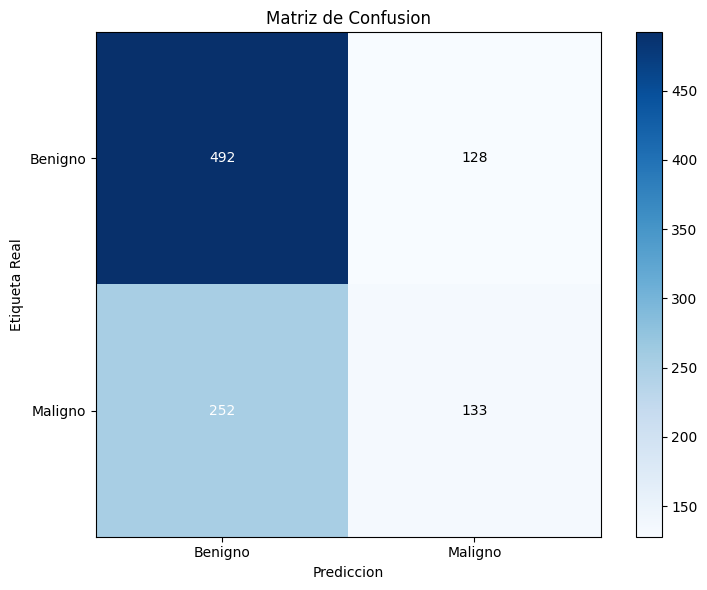

In [18]:
# Matriz de confusion
plot_confusion_matrix(y_true, y_pred)

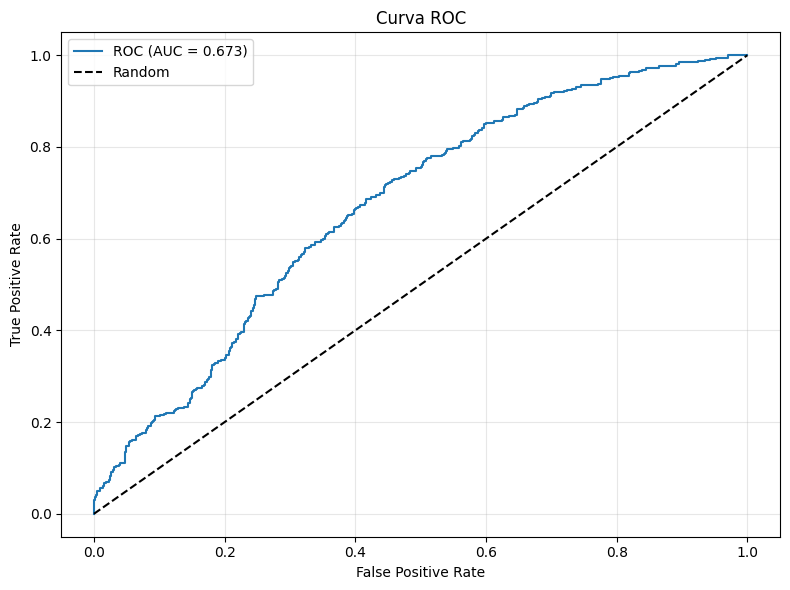

AUC: 0.673


In [19]:
# Curva ROC
try:
    plot_roc_curve(y_true, y_prob)
    print(f"AUC: {roc_auc_score(y_true, y_prob):.3f}")
except Exception as e:
    print(f"No se pudo calcular ROC: {e}")

---

## 7. Inferencia

Ejemplos de clasificacion


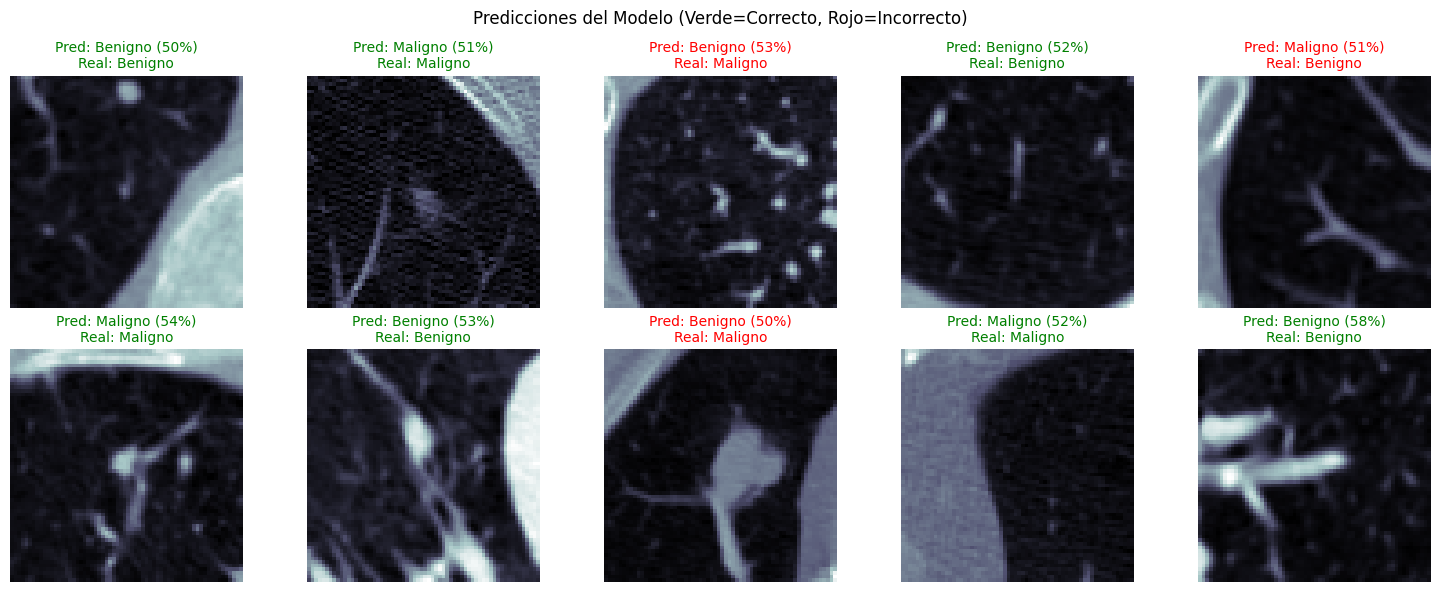

In [20]:
def predict_nodule(model, patch, device):
    """
    Clasifica un nodulo
    
    Args:
        model: Modelo clasificador
        patch: Patch 2D (numpy array o tensor)
        device: Dispositivo (cpu/cuda)
    
    Returns:
        prediction: 0 (benigno) o 1 (maligno)
        probabilities: [prob_benigno, prob_maligno]
    """
    model.eval()
    
    # Preparar input
    if isinstance(patch, np.ndarray):
        # Normalizar si es necesario
        if patch.max() > 1.0:
            patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
        patch = torch.FloatTensor(patch)
    
    if patch.dim() == 2:
        patch = patch.unsqueeze(0).unsqueeze(0)
    elif patch.dim() == 3:
        patch = patch.unsqueeze(0)
    
    patch = patch.to(device)
    
    # Inferencia
    with torch.no_grad():
        outputs = model(patch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
    
    return predicted.item(), probs.squeeze().cpu().numpy()


# Ejemplos de inferencia
print("Ejemplos de clasificacion")
print("="*60)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    idx = np.random.randint(0, len(full_dataset))
    patch, true_label = full_dataset[idx]
    pred, probs = predict_nodule(model, patch, device)
    
    # Visualizar
    axes[i].imshow(patch.squeeze(), cmap='bone')
    
    # Color segun prediccion correcta/incorrecta
    correct = pred == true_label
    color = 'green' if correct else 'red'
    
    axes[i].set_title(f'Pred: {class_names[pred]} ({probs[pred]:.0%})\nReal: {class_names[true_label]}', 
                      color=color, fontsize=10)
    axes[i].axis('off')

plt.suptitle('Predicciones del Modelo (Verde=Correcto, Rojo=Incorrecto)', fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# Guardar modelo final
import shutil

# Mover mejor modelo a carpeta weights
weights_dir = os.path.join(project_root, 'weights')
os.makedirs(weights_dir, exist_ok=True)

final_model_path = os.path.join(weights_dir, 'nodule_classifier.pth')
if os.path.exists('best_classifier.pth'):
    shutil.move('best_classifier.pth', final_model_path)
    print(f"Modelo guardado en: {final_model_path}")

# Resumen
print("\n" + "="*60)
print("RESUMEN DEL NOTEBOOK 04: CLASIFICACION DE NODULOS")
print("="*60)
print(f"\nDataset: Kaggle lungnodemalignancy")
print(f"  - Total: {len(full_dataset)} patches")
print(f"  - Train: {len(train_dataset)}")
print(f"  - Val: {len(val_dataset)}")
print(f"  - Test: {len(test_dataset)}")
print(f"\nModelo: ResNet18 (grayscale)")
print(f"  - Parametros: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nResultados en Test:")
print(f"  - Accuracy: {(y_true == y_pred).mean():.2%}")
try:
    print(f"  - AUC: {roc_auc_score(y_true, y_prob):.3f}")
except:
    pass
print(f"\nModelo guardado en: weights/nodule_classifier.pth")

Modelo guardado en: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\nodule_classifier.pth

RESUMEN DEL NOTEBOOK 04: CLASIFICACION DE NODULOS

Dataset: Kaggle lungnodemalignancy
  - Total: 6691 patches
  - Train: 4683
  - Val: 1003
  - Test: 1005

Modelo: ResNet18 (grayscale)
  - Parametros: 11,171,266

Resultados en Test:
  - Accuracy: 62.19%
  - AUC: 0.673

Modelo guardado en: weights/nodule_classifier.pth
